# ASSIGNMENT 1
**Stress-Testing of Convolutional Neural Networks**

Imports


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models


Seed Control

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Data Transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])


Dataset Download

In [4]:
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:05<00:00, 31.4MB/s]


training-validation split


In [5]:
# Create validation split 90% train, 10% validation
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)   # reproducibility
)

DataLoaders

In [6]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

Show Sample Images

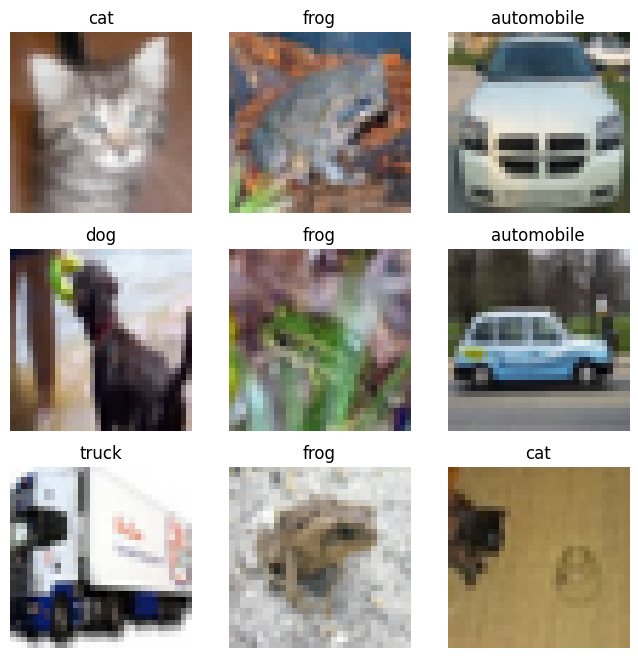

In [7]:
classes = full_train_dataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = images[i].permute(1, 2, 0)
    img = img * torch.tensor((0.2470, 0.2435, 0.2616)) + torch.tensor((0.4914, 0.4822, 0.4465))
    plt.imshow(img)
    plt.title(classes[labels[i]])
    plt.axis('off')

plt.show()

Define the Baseline CNN

In [8]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Model Summary

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


Training Setup
— Loss & Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Loop (Baseline Training)

In [11]:
num_epochs = 10

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    # Append training metrics after the training loop for the current epoch
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    model.eval()
    val_loss_total, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_total += loss.item()
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_total / len(val_loader)
    val_acc = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_acc)


    print(f"Epoch {epoch+1}/{num_epochs}:- Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f},  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")


Epoch 1/10:- Train Loss: 1.4424, Train Acc: 48.0000,  Val Loss:   1.1894, Val Acc:   58.0200
Epoch 2/10:- Train Loss: 1.0249, Train Acc: 63.5400,  Val Loss:   0.9365, Val Acc:   66.9000
Epoch 3/10:- Train Loss: 0.8426, Train Acc: 70.4467,  Val Loss:   0.8592, Val Acc:   69.3200
Epoch 4/10:- Train Loss: 0.7061, Train Acc: 75.5111,  Val Loss:   0.7592, Val Acc:   73.2200
Epoch 5/10:- Train Loss: 0.6046, Train Acc: 78.8933,  Val Loss:   0.7417, Val Acc:   73.4600
Epoch 6/10:- Train Loss: 0.5033, Train Acc: 82.3667,  Val Loss:   0.7345, Val Acc:   74.2800
Epoch 7/10:- Train Loss: 0.4233, Train Acc: 85.2911,  Val Loss:   0.7447, Val Acc:   75.2200
Epoch 8/10:- Train Loss: 0.3441, Train Acc: 87.9422,  Val Loss:   0.7619, Val Acc:   76.0600
Epoch 9/10:- Train Loss: 0.2741, Train Acc: 90.4711,  Val Loss:   0.8418, Val Acc:   74.6800
Epoch 10/10:- Train Loss: 0.2107, Train Acc: 92.7400,  Val Loss:   0.8788, Val Acc:   75.7000


Accuracy & Loss Plots

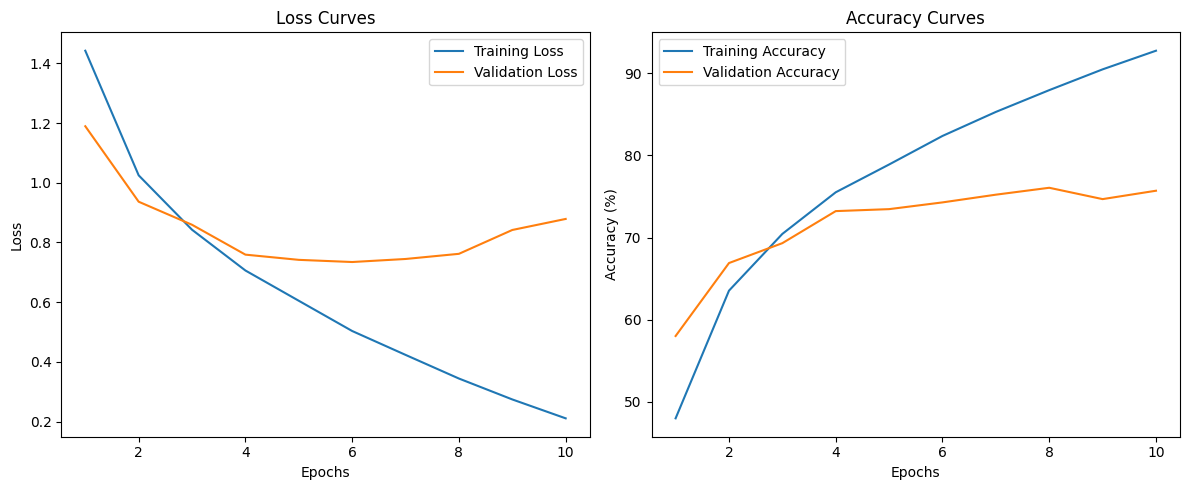

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Evaluation

In [13]:
model.eval()

num_classes = 10
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

#  Accuracy
correct = torch.trace(confusion_matrix)
total = confusion_matrix.sum()
accuracy = 100 * correct / total

#  Precision, Recall, F1 (per class)
precision_per_class = []
recall_per_class = []
f1_per_class = []

for i in range(num_classes):
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    precision_per_class.append(precision)
    recall_per_class.append(recall)
    f1_per_class.append(f1)

#  Macro Averages
macro_precision = torch.mean(torch.tensor(precision_per_class))
macro_recall = torch.mean(torch.tensor(recall_per_class))
macro_f1 = torch.mean(torch.tensor(f1_per_class))

print(f"Test Accuracy      : {accuracy:.2f}%")
print(f"Macro Precision    : {macro_precision:.4f}")
print(f"Macro Recall       : {macro_recall:.4f}")
print(f"Macro F1-score     : {macro_f1:.4f}")


Test Accuracy      : 75.22%
Macro Precision    : 0.7562
Macro Recall       : 0.7522
Macro F1-score     : 0.7528


Eval Mode

In [14]:
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Collect Misclassified Samples with Confidence

Failure Case Extraction

In [15]:
import torch.nn.functional as F

failure_cases = []

confidence_threshold = 0.95

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)

        confidences, predictions = torch.max(probabilities, dim=1)

        for i in range(images.size(0)):
            if predictions[i] != labels[i] and confidences[i] > confidence_threshold:
                failure_cases.append({
                    "image": images[i].cpu(),
                    "true_label": labels[i].item(),
                    "pred_label": predictions[i].item(),
                    "confidence": confidences[i].item()
                })


Count Failures

In [16]:
print(f"Number of high-confidence failure cases: {len(failure_cases)}")


Number of high-confidence failure cases: 477


Visualize Some Failure Cases

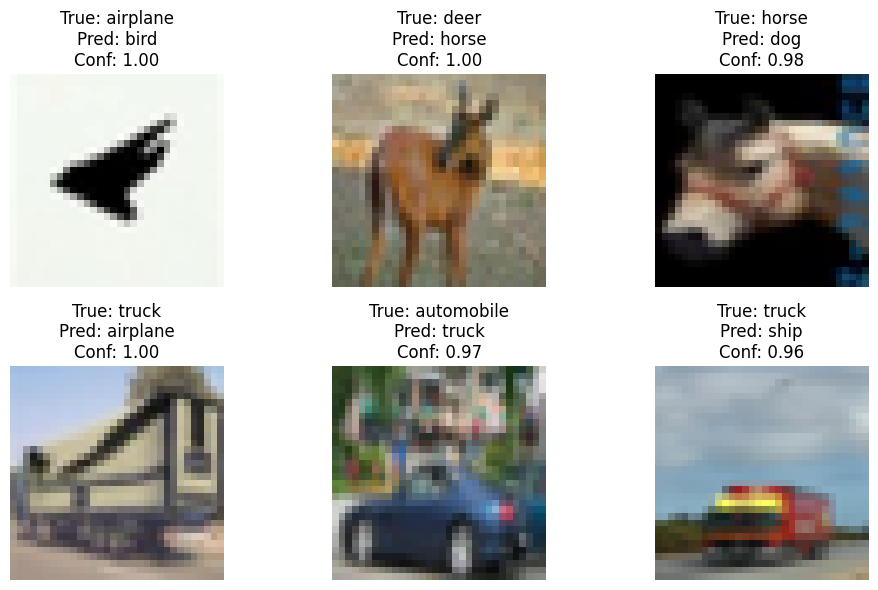

In [17]:
def show_failure_cases(failures, num_images=6):
    plt.figure(figsize=(10, 6))

    for i in range(num_images):
        case = failures[i]
        img = case["image"].permute(1, 2, 0)

        # unnormalize
        img = img * torch.tensor((0.2470, 0.2435, 0.2616)) + \
              torch.tensor((0.4914, 0.4822, 0.4465))

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {classes[case['true_label']]}\n"
            f"Pred: {classes[case['pred_label']]}\n"
            f"Conf: {case['confidence']:.2f}"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_failure_cases(failure_cases, num_images=6)


Save High-Confidence Failure Cases:Create Directory

In [18]:
import os

save_dir = "failure_cases"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving failure cases to folder: {save_dir}")


Saving failure cases to folder: failure_cases


Helper Function to Unnormalize Images

In [19]:
def unnormalize(img):
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3, 1, 1)
    std = torch.tensor((0.2470, 0.2435, 0.2616)).view(3, 1, 1)
    return img * std + mean


Save Failure Images to Disk

In [20]:
from torchvision.utils import save_image

max_images_to_save = 30  # we don't need too many

for idx, case in enumerate(failure_cases[:max_images_to_save]):
    img = unnormalize(case["image"])

    true_label = classes[case["true_label"]]
    pred_label = classes[case["pred_label"]]
    confidence = case["confidence"]

    filename = f"{idx}_true_{true_label}_pred_{pred_label}_conf_{confidence:.2f}.png"
    filepath = os.path.join(save_dir, filename)

    save_image(img, filepath)

print(f"Saved {min(len(failure_cases), max_images_to_save)} failure images.")


Saved 30 failure images.


Display Saved Files

In [21]:
os.listdir(save_dir)


['11_true_dog_pred_bird_conf_1.00.png',
 '7_true_truck_pred_ship_conf_0.98.png',
 '10_true_airplane_pred_ship_conf_1.00.png',
 '13_true_airplane_pred_truck_conf_0.99.png',
 '8_true_bird_pred_airplane_conf_0.98.png',
 '16_true_ship_pred_truck_conf_0.98.png',
 '18_true_truck_pred_airplane_conf_0.99.png',
 '19_true_bird_pred_dog_conf_0.99.png',
 '26_true_bird_pred_ship_conf_0.95.png',
 '4_true_automobile_pred_truck_conf_0.97.png',
 '22_true_deer_pred_horse_conf_1.00.png',
 '23_true_dog_pred_cat_conf_0.98.png',
 '20_true_cat_pred_truck_conf_0.99.png',
 '14_true_truck_pred_automobile_conf_0.96.png',
 '6_true_deer_pred_cat_conf_1.00.png',
 '28_true_bird_pred_airplane_conf_0.95.png',
 '24_true_dog_pred_horse_conf_0.96.png',
 '27_true_truck_pred_automobile_conf_0.96.png',
 '17_true_horse_pred_deer_conf_0.99.png',
 '2_true_horse_pred_dog_conf_0.98.png',
 '29_true_bird_pred_airplane_conf_0.96.png',
 '12_true_automobile_pred_truck_conf_0.97.png',
 '3_true_truck_pred_airplane_conf_1.00.png',
 '15_

In [22]:
import shutil

shutil.make_archive("failure_cases", "zip", save_dir)


'/content/failure_cases.zip'

Grad-CAM: Choose the Target Convolution Layer

For our SimpleCNN, this is conv3 (last conv layer).

Store Activations & Gradients (Hooks)"Grad-CAM Hooks

In [23]:
# Global variables to store activations and gradients
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

# Register hooks on the last conv layer
model.conv3.register_forward_hook(forward_hook)
model.conv3.register_backward_hook(backward_hook)


Grad-CAM Computation

In [24]:
def generate_gradcam(image, class_index):
    model.zero_grad()

    image = image.unsqueeze(0).to(device)
    output = model(image)

    score = output[0, class_index]
    score.backward()

    # Global Average Pooling of gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight activations
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Compute heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)

    # Normalize
    heatmap /= torch.max(heatmap) + 1e-8

    return heatmap.cpu()


Overlay Heatmap on Image — Visualization Helper

In [25]:
import cv2

def show_gradcam(image, heatmap, title="Grad-CAM"):
    img = unnormalize(image).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    heatmap = cv2.resize(heatmap.numpy(), (32, 32))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0

    overlay = 0.6 * img + 0.4 * heatmap

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")
    plt.show()


Apply Grad-CAM to a Failure Case

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


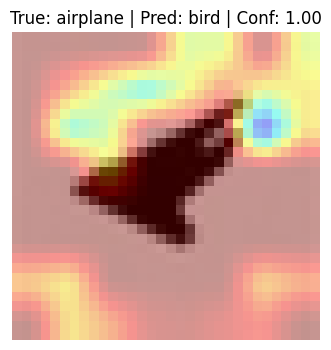

In [26]:
case = failure_cases[0] # Index can be changed

image = case["image"]
true_label = case["true_label"]
pred_label = case["pred_label"]
confidence = case["confidence"]

heatmap = generate_gradcam(image, pred_label)

title = (
    f"True: {classes[true_label]} | "
    f"Pred: {classes[pred_label]} | "
    f"Conf: {confidence:.2f}"
)

show_gradcam(image, heatmap, title)


Repeat for 3 Failure Cases

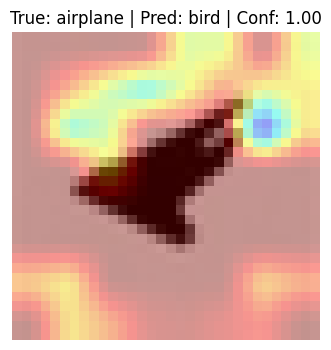

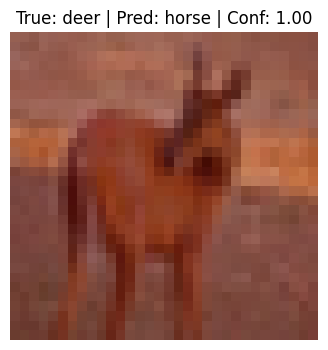

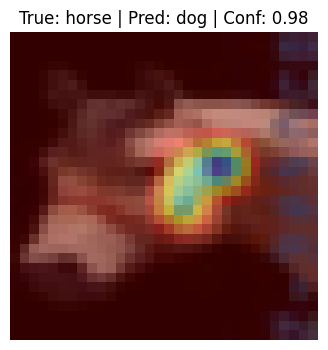

In [27]:
for i in range(3):
    case = failure_cases[i]

    heatmap = generate_gradcam(case["image"], case["pred_label"])

    title = (
        f"True: {classes[case['true_label']]} | "
        f"Pred: {classes[case['pred_label']]} | "
        f"Conf: {case['confidence']:.2f}"
    )

    show_gradcam(case["image"], heatmap, title)


Constrained Improvement (just ONE Change Only):Define Augmented Transforms (only train)— Augmented Transform

In [28]:
train_transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])


Reload Dataset with Augmentation

In [29]:
train_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_aug
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

train_loader_aug = torch.utils.data.DataLoader(
    train_dataset_aug,
    batch_size=128,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)


Reinitialize Model

We must retrain from scratch.

In [30]:
set_seed(42)

model_aug = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)


Train the Augmented Model

In [31]:
num_epochs = 30

train_losses_aug = []
train_accuracies_aug = []

for epoch in range(num_epochs):
    model_aug.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_aug(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader_aug)
    epoch_acc = 100 * correct / total

    train_losses_aug.append(epoch_loss)
    train_accuracies_aug.append(epoch_acc)

    print(f"[Aug] Epoch {epoch+1}/{num_epochs} "
          f"Loss: {epoch_loss:.4f} "
          f"Acc: {epoch_acc:.2f}%")


[Aug] Epoch 1/30 Loss: 1.5865 Acc: 41.64%
[Aug] Epoch 2/30 Loss: 1.2373 Acc: 55.41%
[Aug] Epoch 3/30 Loss: 1.0676 Acc: 62.00%
[Aug] Epoch 4/30 Loss: 0.9479 Acc: 66.66%
[Aug] Epoch 5/30 Loss: 0.8669 Acc: 69.46%
[Aug] Epoch 6/30 Loss: 0.7990 Acc: 71.95%
[Aug] Epoch 7/30 Loss: 0.7575 Acc: 73.35%
[Aug] Epoch 8/30 Loss: 0.7163 Acc: 74.82%
[Aug] Epoch 9/30 Loss: 0.6844 Acc: 76.00%
[Aug] Epoch 10/30 Loss: 0.6596 Acc: 76.72%
[Aug] Epoch 11/30 Loss: 0.6343 Acc: 77.68%
[Aug] Epoch 12/30 Loss: 0.6075 Acc: 78.70%
[Aug] Epoch 13/30 Loss: 0.5940 Acc: 79.00%
[Aug] Epoch 14/30 Loss: 0.5770 Acc: 79.78%
[Aug] Epoch 15/30 Loss: 0.5622 Acc: 80.14%
[Aug] Epoch 16/30 Loss: 0.5476 Acc: 80.74%
[Aug] Epoch 17/30 Loss: 0.5313 Acc: 81.43%
[Aug] Epoch 18/30 Loss: 0.5208 Acc: 81.46%
[Aug] Epoch 19/30 Loss: 0.5041 Acc: 82.28%
[Aug] Epoch 20/30 Loss: 0.5052 Acc: 82.29%
[Aug] Epoch 21/30 Loss: 0.4940 Acc: 82.55%
[Aug] Epoch 22/30 Loss: 0.4843 Acc: 82.90%
[Aug] Epoch 23/30 Loss: 0.4663 Acc: 83.63%
[Aug] Epoch 24/30 Lo

Evaluate Augmented Model

In [32]:
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Re-check Previous Failure Cases

In [33]:
model_aug.eval()

for i in range(3):
    case = failure_cases[i]

    image = case["image"].unsqueeze(0).to(device)
    true_label = case["true_label"]

    with torch.no_grad():
        output = model_aug(image)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    print(
        f"Case {i} | "
        f"True: {classes[true_label]} | "
        f"Pred: {classes[pred.item()]} | "
        f"Conf: {conf.item():.2f}"
    )


Case 0 | True: airplane | Pred: airplane | Conf: 0.75
Case 1 | True: deer | Pred: deer | Conf: 0.74
Case 2 | True: horse | Pred: horse | Conf: 0.49
